PART-I

Loading and splitting data...

Building enhanced vocabulary...
Building enhanced vocabulary (1200 words)...

Computing BoW features...
Applying power transformation...

Training optimized MLP...
Iteration 1, loss = 2.73554756
Validation score: 0.293651
Iteration 2, loss = 1.47691393
Validation score: 0.468254
Iteration 3, loss = 0.77344429
Validation score: 0.519841
Iteration 4, loss = 0.34857233
Validation score: 0.555556
Iteration 5, loss = 0.14698299
Validation score: 0.583333
Iteration 6, loss = 0.06018281
Validation score: 0.634921
Iteration 7, loss = 0.02840191
Validation score: 0.587302
Iteration 8, loss = 0.01442265
Validation score: 0.646825
Iteration 9, loss = 0.00821788
Validation score: 0.646825
Iteration 10, loss = 0.00539762
Validation score: 0.642857
Iteration 11, loss = 0.00416007
Validation score: 0.638889
Iteration 12, loss = 0.00331105
Validation score: 0.642857
Iteration 13, loss = 0.00286941
Validation score: 0.654762
Iteration 14, loss = 0.00252810
Validation scor

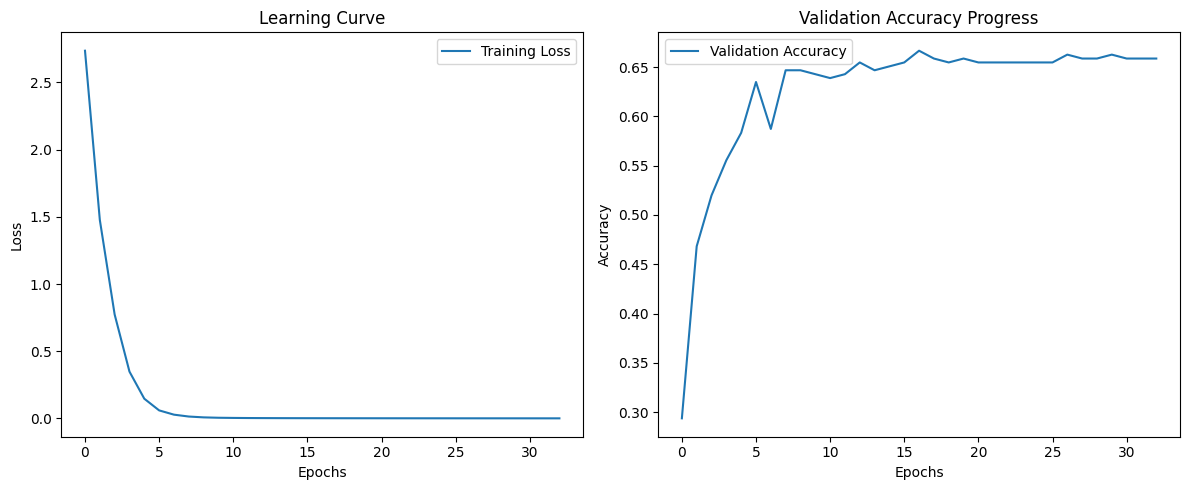

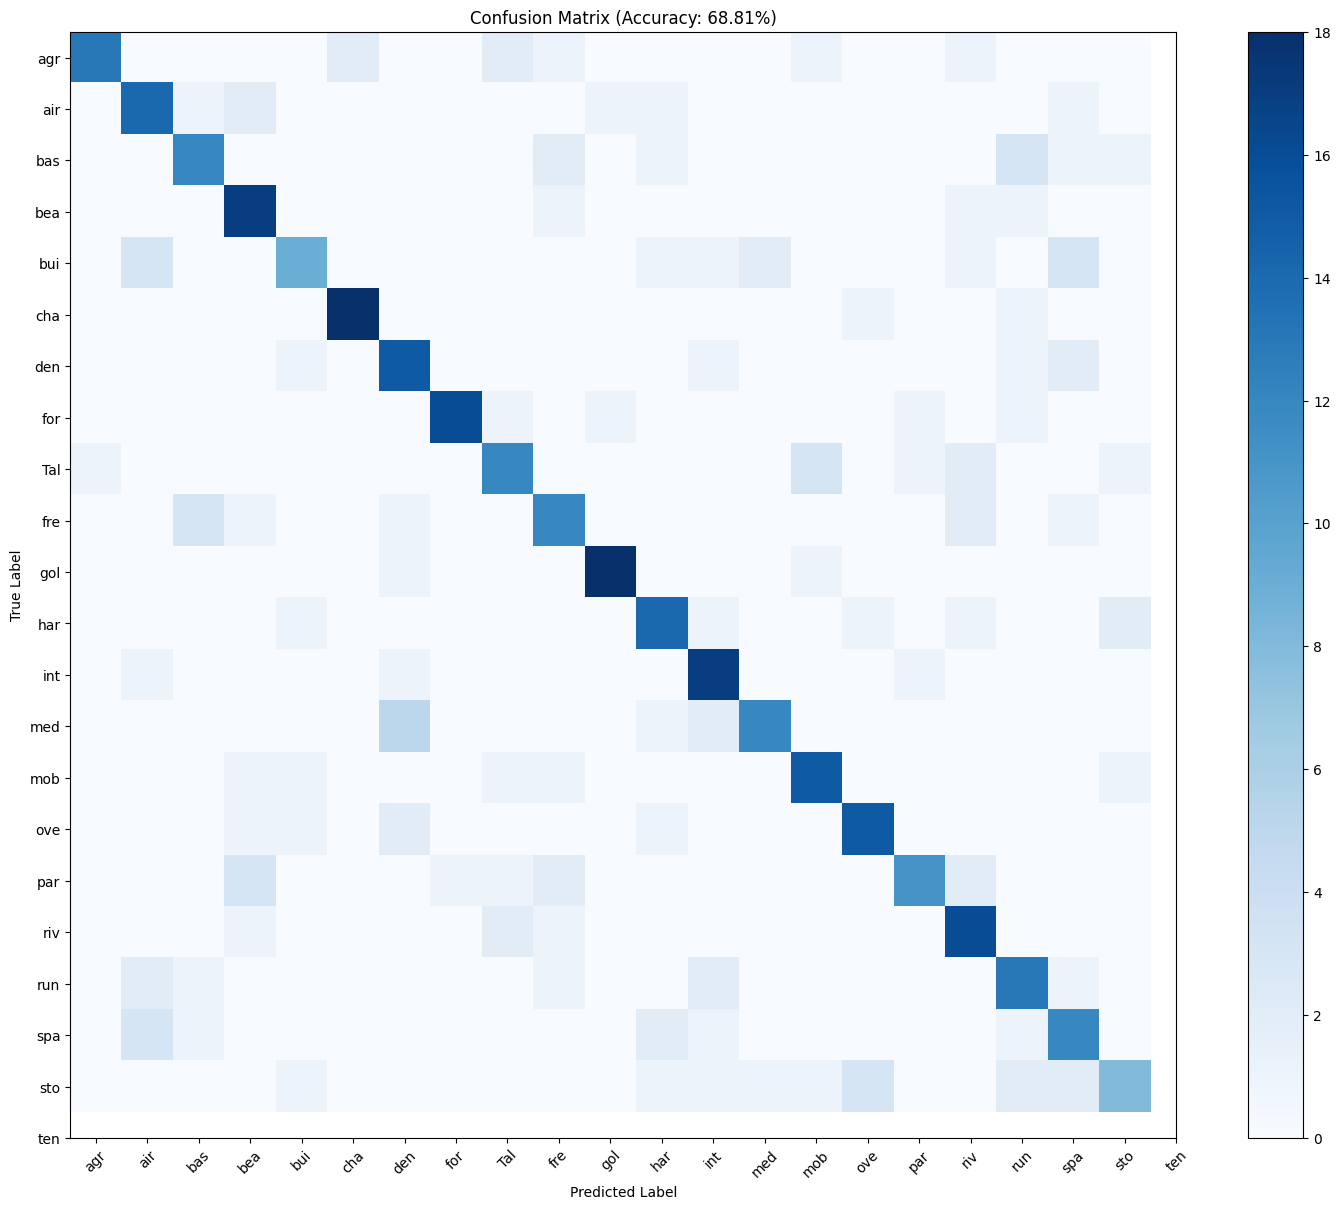

['mlp_model.pkl']

In [17]:
import os
from glob import glob
import numpy as np
from PIL import Image
from time import time
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from cyvlfeat.sift.dsift import dsift
from scipy.spatial import distance
import joblib  # For model saving

# -------------------------------
# Configuration
# -------------------------------
DATA_PATH = 'data'
CATEGORIES = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
              'chaparral', 'denseresidential', 'forest', 'TallBuilding', 'freeway',
              'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
              'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
CATE2ID = {v: k for k, v in enumerate(CATEGORIES)}
ABBR_CATEGORIES = [i[:3] for i in CATEGORIES]


VOCAB_SIZE = 1200          
MLP_LAYERS = (512, 256, 128) 
LEARNING_RATE = 0.001       
REGULARIZATION = 0.0001     
BATCH_SIZE = 256            

# -------------------------------
# Enhanced Data Loading with Augmentation Suggestions
# -------------------------------
def get_image_paths(data_path, categories):
    """Load image paths with potential augmentation expansion"""
    data_paths = []
    data_labels = []
    for category in categories:
        image_paths = glob(os.path.join(data_path, category, '*.tif'))
        
    
        
        data_paths.extend(image_paths)
        data_labels.extend([category] * len(image_paths))
    
    return train_test_split(data_paths, data_labels, 
                           test_size=0.2, random_state=42, stratify=data_labels)

print("Loading and splitting data...")
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(DATA_PATH, CATEGORIES)
train_labels_np = np.array([CATE2ID[l] for l in train_labels])
test_labels_np = np.array([CATE2ID[l] for l in test_labels])

# -------------------------------
# Enhanced Feature Extraction
# -------------------------------
def extract_sift_features(path):
    """Extract SIFT features with suggested multi-scale support"""
    img = np.asarray(Image.open(path).convert("L"), dtype='float32')
    
    # Base features
    _, descriptors = dsift(img, step=[4, 4], fast=True)

    
    return descriptors

def build_vocabulary(image_paths, vocab_size):
    """Build optimized vocabulary with feature selection suggestions"""
    print(f"Building enhanced vocabulary ({vocab_size} words)...")
    
    # Extract features with parallel processing
    with Pool(cpu_count()) as pool:
        features = pool.map(extract_sift_features, image_paths)
    features = np.concatenate(features).astype('float32')
    
    
    # Optimized clustering
    kmeans = MiniBatchKMeans(n_clusters=vocab_size, init='k-means++',
                            batch_size=2048, n_init=5, random_state=42)
    kmeans.fit(features)
    return kmeans.cluster_centers_

# -------------------------------
# Spatial Pyramid Matching (SPM) Implementation Suggestion
# -------------------------------
def spatial_pyramid_histogram(path, vocab, levels=2):
    """Suggested SPM implementation (uncomment to use)"""
    img = np.asarray(Image.open(path).convert("L"), dtype='float32')
    hist = []
    
    hist = np.array(hist)
    return hist / hist.sum()

# -------------------------------
# Feature Engineering Pipeline
# -------------------------------
print("\nBuilding enhanced vocabulary...")
vocab = build_vocabulary(train_image_paths, VOCAB_SIZE)

print("\nComputing BoW features...")
# Use either standard BoW or SPM version
train_feats = get_bags_of_sifts(train_image_paths, vocab)  # Standard
# train_feats = [spatial_pyramid_histogram(p, vocab) for p in train_image_paths]  # SPM
train_feats = np.array(train_feats)

test_feats = get_bags_of_sifts(test_image_paths, vocab)    # Standard
# test_feats = [spatial_pyramid_histogram(p, vocab) for p in test_image_paths]    # SPM
test_feats = np.array(test_feats)

# Advanced Normalization
print("Applying power transformation...")
pt = PowerTransformer()
train_feats = pt.fit_transform(train_feats)
test_feats = pt.transform(test_feats)

# -------------------------------
# Optimized MLP Architecture
# -------------------------------
mlp = MLPClassifier(
    hidden_layer_sizes=MLP_LAYERS,
    activation='relu',
    solver='adam',
    alpha=REGULARIZATION,
    learning_rate_init=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=15,
    max_iter=200,
    shuffle=True,
    random_state=42,
    verbose=True
)

print("\nTraining optimized MLP...")
mlp.fit(train_feats, train_labels_np)

# -------------------------------
# Evaluation and Visualization
# -------------------------------
test_pred = mlp.predict(test_feats)
test_acc = accuracy_score(test_labels_np, test_pred)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mlp.validation_scores_, label='Validation Accuracy')
plt.title('Validation Accuracy Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels_np, test_pred)
plt.figure(figsize=(15,12))
plot_confusion_matrix(cm, ABBR_CATEGORIES, title=f'Confusion Matrix (Accuracy: {test_acc:.2%})')
plt.show()

# Save model components
joblib.dump(vocab, 'vocab.pkl')
joblib.dump(pt, 'preprocessor.pkl')
joblib.dump(mlp, 'mlp_model.pkl')



PART-II

Epoch [1/50], Train Loss: 2.8494, Test Loss: 2.7268, Train Acc: 0.1631, Test Acc: 0.1595
Epoch [2/50], Train Loss: 2.4606, Test Loss: 2.7698, Train Acc: 0.2982, Test Acc: 0.1810
Epoch [3/50], Train Loss: 2.1511, Test Loss: 3.1893, Train Acc: 0.4131, Test Acc: 0.1548
Epoch [4/50], Train Loss: 1.8608, Test Loss: 2.7536, Train Acc: 0.5143, Test Acc: 0.1833
Epoch [5/50], Train Loss: 1.5873, Test Loss: 2.8215, Train Acc: 0.6077, Test Acc: 0.2000
Epoch [6/50], Train Loss: 1.2641, Test Loss: 3.2465, Train Acc: 0.7214, Test Acc: 0.1690
Epoch [7/50], Train Loss: 1.0661, Test Loss: 3.2265, Train Acc: 0.7625, Test Acc: 0.1905
Epoch [8/50], Train Loss: 0.8793, Test Loss: 3.3849, Train Acc: 0.8167, Test Acc: 0.1881
Epoch [9/50], Train Loss: 0.7222, Test Loss: 3.9262, Train Acc: 0.8470, Test Acc: 0.1595
Epoch [10/50], Train Loss: 0.6206, Test Loss: 6.4127, Train Acc: 0.8625, Test Acc: 0.1333
Epoch [11/50], Train Loss: 0.5769, Test Loss: 4.5633, Train Acc: 0.8798, Test Acc: 0.1238
Epoch [12/50], Trai

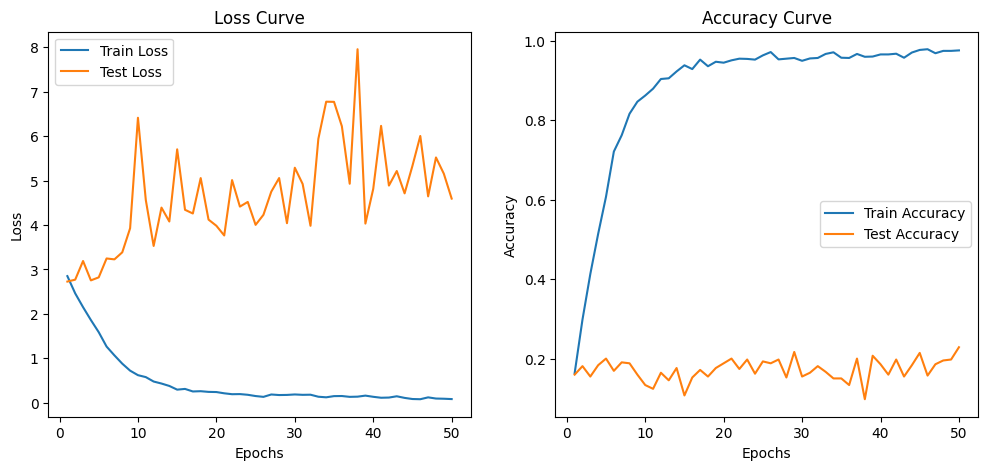

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import os

# Function to load and preprocess images
def load_images(image_paths, img_size=(72, 72)):
    images = []
    for path in image_paths:
        img = Image.open(path).convert("L")  # Convert to grayscale
        img = img.resize(img_size)  # Resize to 72x72
        img = np.array(img, dtype=np.float32).flatten() / 255.0  # Flatten and normalize
        images.append(img)
    return np.array(images)

# Load and preprocess train and test images
train_images = load_images(train_image_paths)
test_images = load_images(test_image_paths)

# Convert labels to numerical format
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(train_images, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_images, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

# Create DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define an improved three-layer MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Model parameters
input_size = 72 * 72  # Flattened image size
hidden_size1 = 512
hidden_size2 = 256
num_classes = len(CATEGORIES)

# Initialize model, loss function, and optimizer
model = MLPClassifier(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Reduced learning rate

# Training loop
epochs = 50  # Increased epochs
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Evaluate the model
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()